<a href="https://colab.research.google.com/github/yevheniiamoiseieva/nlp_lab5/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
VALIDATION_CORPUS = "validation_corpus.csv"
VALIDATION_QUERIES = "validation_queries.csv"

val_corpus_df = pd.read_csv(VALIDATION_CORPUS, sep="|")

print("Назви стовпчиків у validation_corpus.csv:")
print(val_corpus_df.columns)

val_queries_df = pd.read_csv(VALIDATION_QUERIES, sep="|", converters={'expected_results': pd.eval})

print("Назви стовпчиків у validation_queries.csv:")
print(val_queries_df.columns)

Назви стовпчиків у validation_corpus.csv:
Index(['Unnamed: 0', 'description', 'display name', 'category', 'id'], dtype='object')
Назви стовпчиків у validation_queries.csv:
Index(['Unnamed: 0', 'queries', 'expected_results'], dtype='object')


In [11]:
# 1. Встановлення бібліотек
!pip install -q sentence-transformers scikit-learn pandas matplotlib seaborn transformers

# 2. Імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Правильний імпорт CrossEncoder
from sentence_transformers import SentenceTransformer, InputExample, losses, util, CrossEncoder
from torch.utils.data import DataLoader

# 3. Конфігурація файлів
TRAIN_FILE = "train_triplet.csv"
VALIDATION_CORPUS = "validation_corpus.csv"
VALIDATION_QUERIES = "validation_queries.csv"

# 4. Завантаження та підготовка валідаційних даних
val_corpus_df = pd.read_csv(VALIDATION_CORPUS, sep="|")
val_queries_df = pd.read_csv(VALIDATION_QUERIES, sep="|", converters={'expected_results': pd.eval})

corpus_texts = val_corpus_df['description'].tolist()

queries_texts = val_queries_df['queries'].tolist()

expected_results = val_queries_df['expected_results'].tolist()

# 5. Підготовка тренувальних даних
train_df = pd.read_csv(TRAIN_FILE, sep=",")
# Створення позитивних пар для MultipleNegativesRankingLoss
train_examples = [InputExample(texts=[row['anchor'], row['positive']]) for _, row in train_df.iterrows()]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [12]:
# Створення та навчання моделі
model_name = "cointegrated/rubert-tiny2" # Швидкий мультиязичний енкодер
model = SentenceTransformer(model_name)

# Loss-функція: MultipleNegativesRankingLoss
train_loss = losses.MultipleNegativesRankingLoss(model=model)
num_epochs = 4

# Навчання
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=100
)

# Створення ембедінгів
corpus_embeddings = model.encode(corpus_texts, convert_to_tensor=True)
query_embeddings = model.encode(queries_texts, convert_to_tensor=True)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,1.826000
1000,1.496000
1500,1.405100
2000,1.348900
2500,1.327200


In [13]:
# 3.1. Семантичний пошук (кандидати для реранкінгу)
top_k = 20 # Беремо більшу кількість для реранкінгу
all_results_semantic = []
for q_emb in query_embeddings:
    hits = util.semantic_search(q_emb, corpus_embeddings, top_k=top_k)
    all_results_semantic.append([h['corpus_id'] for h in hits[0]])

# 3.2. Реранкінг (Cross-Encoder)
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
rerank_top_n = 10 # Кінцева кількість результатів
all_results_reranked = []

for i, query in enumerate(queries_texts):
    candidate_indices = all_results_semantic[i]
    candidate_texts = [corpus_texts[idx] for idx in candidate_indices]
    model_inputs = [[query, doc] for doc in candidate_texts]

    # Оцінка релевантності
    rerank_scores = reranker.predict(model_inputs)

    # Сортування
    scored_candidates = sorted(zip(candidate_indices, rerank_scores), key=lambda x: x[1], reverse=True)
    all_results_reranked.append([idx for idx, score in scored_candidates[:rerank_top_n]])


--- Результати метрик ---
 | Метрика  | Семантичний пошук | З реранкінгом |
 |:---------|:-----------------:|:-------------:|
 | Precision@5 | 0.0218        | 0.0618      |
 | Recall@5    | 0.0109        | 0.0309      |
 | F1-score@5  | 0.0145        | 0.0412      |
 | MAP      | 0.0267        | 0.0697      |


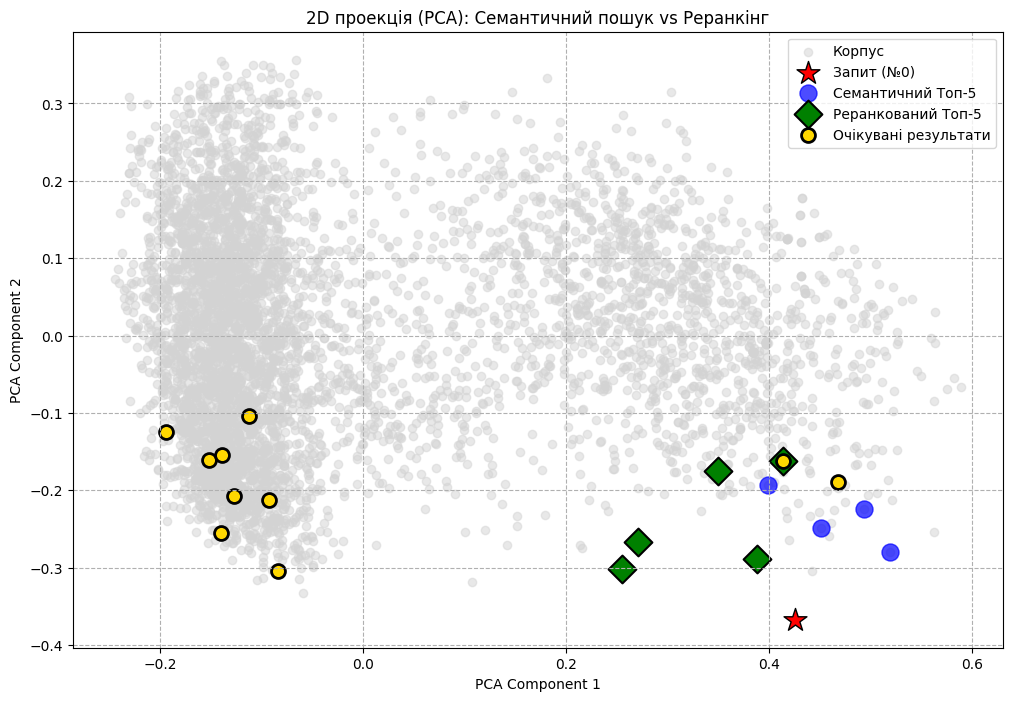

In [14]:
# 4.1. Функції метрик
def precision_recall_fscore_at_k(results, expected, k=5):
    precisions, recalls, f1s = [], [], []
    for res, exp in zip(results, expected):
        res_k, exp_k = set(res[:k]), set(exp)
        tp = len(res_k & exp_k)
        p = tp / k
        r = tp / len(exp_k) if len(exp_k) > 0 else 0
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

def mean_average_precision(results, expected, ks=[2, 5, 10]):
    maps = []
    for res, exp in zip(results, expected):
        ap_list = []
        for k in ks:
            res_k, exp_k = set(res[:k]), set(exp)
            tp = len(res_k & exp_k)
            ap_list.append(tp / k)
        maps.append(np.mean(ap_list))
    return np.mean(maps)

# 4.2. Обчислення та вивід
k_metric = 5
p5_sem, r5_sem, f1_5_sem = precision_recall_fscore_at_k(all_results_semantic, expected_results, k=k_metric)
map_sem = mean_average_precision(all_results_semantic, expected_results)
p5_rerank, r5_rerank, f1_5_rerank = precision_recall_fscore_at_k(all_results_reranked, expected_results, k=k_metric)
map_rerank = mean_average_precision(all_results_reranked, expected_results)

print("\n--- Результати метрик ---")
print(" | Метрика  | Семантичний пошук | З реранкінгом |")
print(" |:---------|:-----------------:|:-------------:|")
print(f" | Precision@{k_metric} | {p5_sem:.4f}        | {p5_rerank:.4f}      |")
print(f" | Recall@{k_metric}    | {r5_sem:.4f}        | {r5_rerank:.4f}      |")
print(f" | F1-score@{k_metric}  | {f1_5_sem:.4f}        | {f1_5_rerank:.4f}      |")
print(f" | MAP      | {map_sem:.4f}        | {map_rerank:.4f}      |")

# 4.3. Візуалізація
all_embeddings = model.encode(corpus_texts + queries_texts)
pca = PCA(n_components=2)
reduced_emb = pca.fit_transform(all_embeddings)
corpus_points = reduced_emb[:len(corpus_texts)]
query_points  = reduced_emb[len(corpus_texts):]
query_index_to_plot = 0
top_sem = all_results_semantic[query_index_to_plot][:5]
top_rerank = all_results_reranked[query_index_to_plot][:5]
top_expected = expected_results[query_index_to_plot]

plt.figure(figsize=(12, 8))
plt.scatter(corpus_points[:, 0], corpus_points[:, 1], color='lightgray', alpha=0.5, label='Корпус')
plt.scatter(query_points[query_index_to_plot, 0], query_points[query_index_to_plot, 1], color='red', marker='*', s=300, edgecolor='black', label=f'Запит (№{query_index_to_plot})')
for i, idx in enumerate(top_sem):
    plt.scatter(corpus_points[idx, 0], corpus_points[idx, 1], color='blue', s=150, alpha=0.7, label='Семантичний Топ-5' if i == 0 else "")
for i, idx in enumerate(top_rerank):
    plt.scatter(corpus_points[idx, 0], corpus_points[idx, 1], color='green', marker='D', s=200, edgecolor='black', linewidth=1.5, label='Реранкований Топ-5' if i == 0 else "")
for i, idx in enumerate(top_expected):
    plt.scatter(corpus_points[idx, 0], corpus_points[idx, 1], color='gold', marker='o', s=100, edgecolor='black', linewidth=2, label='Очікувані результати' if i == 0 else "")
plt.legend()
plt.title(f"2D проекція (PCA): Семантичний пошук vs Реранкінг")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True, linestyle='--')
plt.show()